In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.signal
import cv2
%matplotlib inline

In [2]:
import os
from tqdm import tqdm

In [3]:
root = "dataset"
os.listdir(root)

['coastal', 'mountains', 'plains', 'urban']

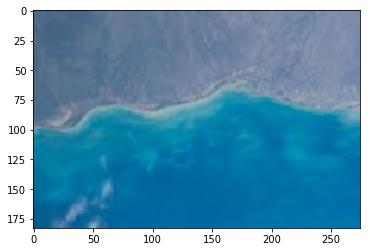

In [4]:
test_img = cv2.imread('dataset/coastal/1.jpg')

test_img = cv2.GaussianBlur(test_img, (3,3), 0)

def display_image(img):
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
display_image(test_img)

In [5]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def smooth_image(img):
    return cv2.GaussianBlur(img, (3,3), 0)

def im2col(A,BLKSZ):   

    # Parameters
    M,N = A.shape
    col_extent = N - BLKSZ[1] + 1
    row_extent = M - BLKSZ[0] + 1

    # Get Starting block indices
    start_idx = np.arange(BLKSZ[0])[:,None]*N + np.arange(BLKSZ[1])

    # Get offsetted indices across the height and width of input array
    offset_idx = np.arange(row_extent)[:,None]*N + np.arange(col_extent)

    # Get all actual indices & index into input array for final output
    return np.take (A,start_idx.ravel()[:,None] + offset_idx.ravel())

def coltfilt(A, size):
    
    original_shape = np.shape(A)
    a,b = 0, 0
    if(size%2==0):
        a, b = int(size/2)-1, int(size/2)
    else:
        a,b = int(size/2), int(size/2)
    A = np.lib.pad(A, (a, b), 'constant')
    Acol = im2col(A, (size, size))
    rc = np.floor((Acol.max(axis=0) - Acol.min(axis=0))/float(size)) + 1
    return np.reshape(rc, original_shape)

def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def mat2gray(mat):
    maxI = np.max(mat)
    minI = np.min(mat)
    gray = (mat[:,:] - minI) / (maxI - minI)
    return gray
    
#------- computing the slope using linear regression -------
def fractal_aug(image):
    
    image = smooth_image(image)
    
    n_channels = len(np.shape(image))

    if(n_channels == 3):
        image=rgb2gray(image)
    
    image = smooth_image(image)

    image *= 255.0
    imrows, imcols = np.shape(image)
    
    B = np.zeros((6, imrows, imcols))

    print("Calculating Differential Box Counting image")

    for r in range(2,8):
        mask = matlab_style_gauss2D((r,r), r/2.0)
        im = scipy.signal.convolve2d(image, mask, mode='same')
        F = (coltfilt(im, r))*(49/(r**2))
        B[r - 2] = np.log(F)

    print("Calculating FD image")

    i = np.log(range(2,8)) #Normalised scale range vector

    Nxx = np.dot(i,i) - (np.sum(i)**2)/6
    FD = np.zeros((imrows,imcols))

    for m in range(1,imrows):
        for n in range(1,imcols):
            fd = [B[5,m,n], B[4,m,n], B[3,m,n], B[2,m,n], B[1,m,n], B[0,m,n]] #Number of boxes multiscale vector
            Nxy = np.dot(i,fd) - (sum(i)*sum(fd))/6
            FD[m,n] = Nxy/Nxx # slope of the linear regression line

    tmp = np.zeros(np.shape(B))
    for r in range(2,8):
        tmp[r-2, :, :] = FD * np.log(m)

    intercept = np.mean(B - tmp, axis=0)

    FDB = mat2gray(FD);

    intercept_image = mat2gray(intercept)
    
    plt.imshow(intercept_image, cmap='gray')
    plt.show()
    
    return intercept

Calculating Differential Box Counting image
Calculating FD image


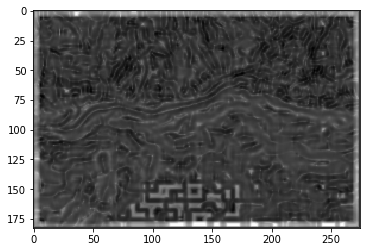

In [6]:
lol = fractal_aug(test_img)

In [7]:
type(lol)

numpy.ndarray

In [8]:
lol[:,:,np.newaxis].shape

(183, 275, 1)

In [9]:
np.dstack((lol[:,:,np.newaxis], np.zeros(lol.shape)[:,:,np.newaxis] )).shape

(183, 275, 2)

116

In [20]:
def load_images_to_numpy(root):
    # counting number of images
    count_imgs = 0
    count_classes = 0
    num = 0
    reqd_dim = 64, 64
    
    # reshaping images
    #min_wd, min_ht, max_wd, max_ht = 5000,5000,0,0
    
    # counting no of images in the 'dataset' folder
    for folder in os.listdir(root):
        count_classes+=1
        count_imgs+=len(os.listdir(os.path.join(root, folder)))

    print(count_imgs, 'images found in', count_classes, 'classes')
    
    # initializing empty array
    imgs = np.empty((count_imgs, reqd_dim, reqd_dim), dtype='uint16')
 
    # reading and loading image
    for fold in tqdm(os.listdir(root)):
        for f in os.listdir(os.path.join(root, fold)):
            image_path = os.path.join(root, fold, f)
            img = cv2.imread(image_path)
            
            # preprocessing: convert to RGB and resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(reqd_dim, reqd_dim), interpolation=cv2.INTER_CUBIC)

            # storing image in numpy array
            imgs[num, :, :] = img




            ## checking max and min dimensions
            #if img.shape[0] > max_wd:
            #    max_wd = img.shape[0]
            #if img.shape[1] > max_ht:
            #    max_ht = img.shape[1]
            #if img.shape[0] < min_wd:
            #    min_wd = img.shape[0]
            #if img.shape[1] < min_ht:
            #    min_ht = img.shape[1]
            
        
        
            #print(min_wd, min_ht)
            #print(max_wd, max_ht)
    return img

In [21]:
train = load_images_to_numpy(root)

116 images found in 4 classes


TypeError: 'tuple' object cannot be interpreted as an integer